In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import sys



In [3]:
%load_ext tensorboard

In [21]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 10
        self.horizontal_distance_between_neurons = 5
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

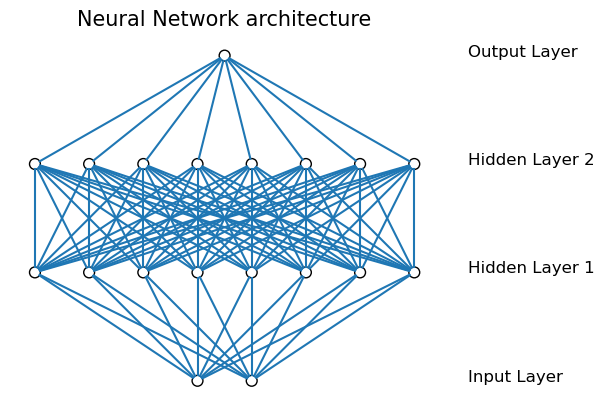

In [22]:
network = DrawNN( [2,8,8,1] )
network.draw()

In [25]:
! pip3 install nnv

In [26]:
from nnv import NNV


ModuleNotFoundError: No module named 'nnv'

In [27]:
import numpy as np
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.lines as lines
import matplotlib.pyplot as plt



class Element:
    def __init__(self, top, left, width, height, color):
        self.top = top
        self.left = left
        self.width = width
        self.height = height
        self.color = color

    def get_center_x(self):
        return self.left + self.width / 2

    def get_center_y(self):
        return self.top - self.height / 2

    def get_bottom(self):
        return self.top - self.height

    def move_y(self, delta):
        self.top += delta


class Node(Element):
    def __init__(self, top, left, radius, color="gray"):
        Element.__init__(self, top, left, radius*2, radius*2, color=color)
        self.radius = radius

    def get_radius(self):
        return self.radius

    def get_edge_out_position(self):
        return [self.left + self.width, self.top - self.height*0.5]

    def get_edge_in_position(self):
        return [self.left, self.top - self.height*0.5]

    def render(self, m_ax):
        circle = Circle((self.get_center_x(), self.get_center_y()), self.get_radius(), color=self.color, zorder=10)
        m_ax.add_patch(circle)
        return circle


def get_edge_positions(from_node, to_node):
    o = from_node.get_edge_out_position()
    d = to_node.get_edge_in_position()
    return ([o[0], d[0]], [o[1], d[1]])

def connect_nodes(node1, node2, ax, edges_color, edges_width):
    (a,b) = get_edge_positions(node1, node2)
    l1 = lines.Line2D(a,b, color=edges_color, linewidth=edges_width)
    ax.add_line(l1)



class Layer():
    def __init__(self, left, num_nodes, node_radius, title=None, spacing_nodes = 1, max_num_nodes_visible=None, color="gray", font_size=36, edges_color="lightGray", edges_width=4):
        self.nodes = []
        self.top = 0
        self.title = title
        self.font_size = font_size
        self.edges_color = edges_color
        self.edges_width = edges_width
        top = 0

        self.three_dots = None
        three_dots_index = -1
        restart_index = -1
        if (max_num_nodes_visible is not None) and (max_num_nodes_visible < num_nodes):
            three_dots_index = (max_num_nodes_visible // 2)
            restart_index = num_nodes - three_dots_index
        for i in range(num_nodes):
            if i > three_dots_index and i < restart_index:
                continue
            if i == three_dots_index:
                self.three_dots = ThreeDots(top, x = left + node_radius, dot_radius = max(min(4,node_radius*0.5),1), spacing = 2)
                top = self.three_dots.get_bottom() - spacing_nodes
            else:
                node = Node(top, left, radius = node_radius, color = color)
                self.nodes.append(node)
                top = node.get_bottom() - spacing_nodes
        self.bottom = top

    def set_top(self, top):
        delta = top - self.top
        for n in self.nodes:
            n.move_y(delta)
        self.top += delta
        self.bottom += delta


    def get_left(self):
        return self.nodes[0].left

    def get_width(self):
        return self.nodes[0].width

    def get_center_x(self):
        return self.get_left() + self.get_width() /2

    def get_right(self):
        return self.get_left() + self.get_width()

    def get_height(self):
        return abs(self.bottom - self.top)

    def get_bottom(self):
        return self.bottom

    def render(self, mAx):
        for n in self.nodes:
            n.render(mAx)
        if (self.three_dots is not None):
            self.three_dots.render(mAx)
        if (self.title is not None):
            mAx.text(x=self.get_center_x(), y=10, s=self.title, fontsize=self.font_size, horizontalalignment='center')


    def fully_connect(self, layer2, mAx):
        for a in self.nodes:
            for b in layer2.nodes:
                connect_nodes(a,b, mAx, self.edges_color, self.edges_width)


class ThreeDots(Layer):
    def __init__(self, top, x, dot_radius = 4, spacing = 2, color = "lightGray"):
        left = x - dot_radius
        Layer.__init__(self, left=left, num_nodes=3, node_radius=dot_radius, spacing_nodes=spacing, color=color)
        self.set_top(top)


class NNV():
    def __init__(self, layers_list, spacing_layer = 60, spacing_nodes=1, align = "middle", max_num_nodes_visible = 4, node_radius = 20, font_size = 18):
        self.layers = []
        left = 0
        self.left = 0
        self.spacing_layer = spacing_layer
        max_height = 0
        for l in layers_list:
            layer = Layer(left=left, num_nodes=l["units"], node_radius=node_radius, title=l["title"], color=l.get("color", "gray"), max_num_nodes_visible=max_num_nodes_visible, font_size=font_size, spacing_nodes=spacing_nodes, edges_color=l.get("edges_color","lightGray"), edges_width=l.get("edges_width", 4))
            self.layers.append(layer)
            left = layer.get_right() + self.spacing_layer
            max_height = max(max_height, layer.get_height())
        self.right = left

        # setting the alignment
        if (align == "top"):
            pass
        if (align == "middle"):
            for l in self.layers:
                empty_space = max_height - l.get_height()
                l.set_top(-empty_space/2)

    def render(self, save_to_file=None, do_not_show=False):
        mFig, mAx = plt.subplots()

        #creating layers
        for l in self.layers:
            l.render(mAx)


        #creating edges between nodes
        for i in range(len(self.layers) - 1):
            self.layers[i].fully_connect(self.layers[i+1], mAx)



        mAx.set_aspect("equal") # same spacing on both axis
        mAx.autoscale(enable=True, axis='both', tight=None) # fit axis values

        # plt.rcParams["figure.figsize"] = (200,10)
        plt.axis('off')
        if (save_to_file is not None):
            plt.savefig(save_to_file, bbox_inches='tight')

        if do_not_show == False:
            plt.show()

        return mFig, 

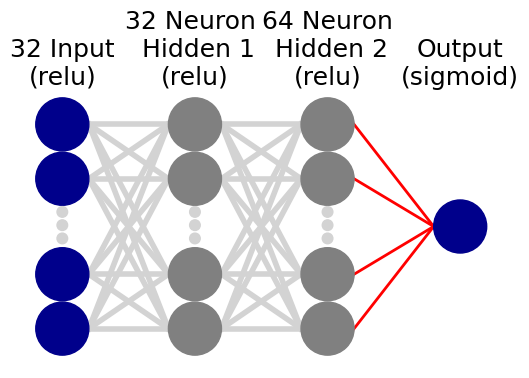

(<Figure size 640x480 with 1 Axes>,)

In [35]:

layersList = [
    {"title":"32 Input\n(relu)", "units": 32, "color": "darkBlue"},
    {"title":"32 Neuron \n Hidden 1\n(relu)", "units": 32},
    {"title":" 64 Neuron \n Hidden 2\n(relu)", "units": 64, "edges_color":"red", "edges_width":2},
    {"title":"Output\n(sigmoid)", "units": 1,"color": "darkBlue"},
]

NNV(layersList).render(save_to_file="my_example.png")

In [36]:
! pip3 install kviz

     |████████████████████████████████| 3.4 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 217.2 MB 95.8 MB/s eta 0:00:011
     |████████████████████████████████| 3.4 MB 104.1 MB/s eta 0:00:01
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
     |████████████████████████████████| 5.6 MB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 15.9 MB/s eta 0:00:01
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     |████████████████████████████████| 1.7 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 173 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 440 kB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 25.3 MB/s eta 0:00:01


  ERROR: Command errored out with exit status 1:
   command: /Users/Gideon/opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/67/dbt0zf1x41q5bnr6syjzgy5w0000gn/T/pip-install-hnh0020b/pygraphviz/setup.py'"'"'; __file__='"'"'/private/var/folders/67/dbt0zf1x41q5bnr6syjzgy5w0000gn/T/pip-install-hnh0020b/pygraphviz/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/67/dbt0zf1x41q5bnr6syjzgy5w0000gn/T/pip-wheel-ki04rjbv
       cwd: /private/var/folders/67/dbt0zf1x41q5bnr6syjzgy5w0000gn/T/pip-install-hnh0020b/pygraphviz/
  Complete output (73 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9-x86_64-3.8/pygraphviz
  copying pygraphviz/scraper.py -> build/lib

In [ ]:
 dg = DenseGraph(model)
    dg.render()

In [7]:
import visualkeras


In [11]:
import keras.models

In [16]:
model=keras.models.load_model('../GideonModelv1')

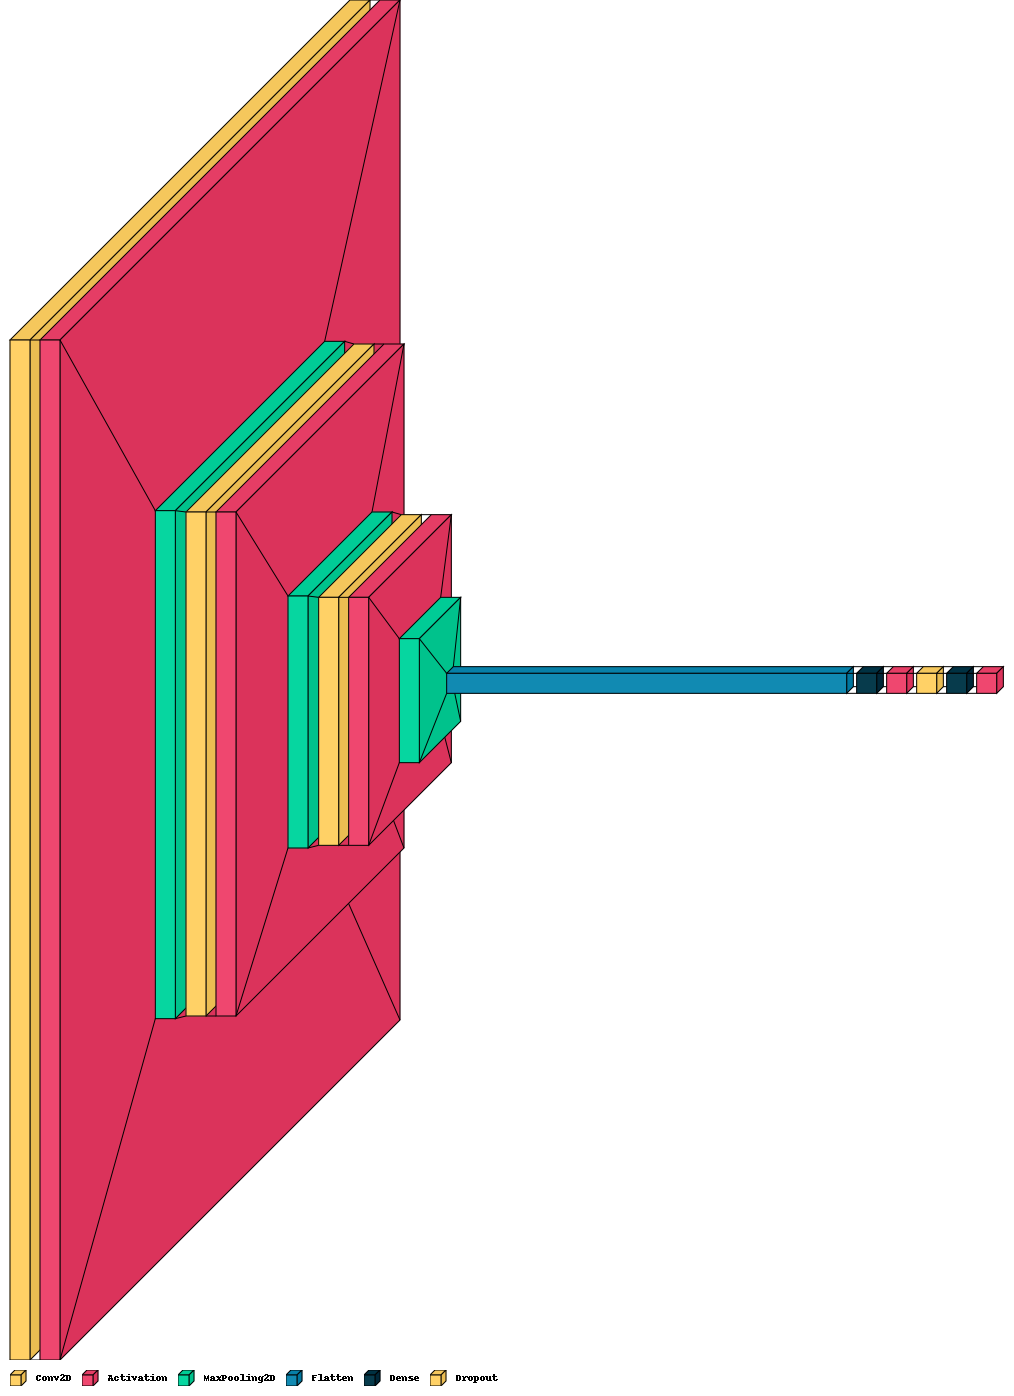

In [17]:

visualkeras.layered_view(model,legend=True, draw_volume=True)

In [18]:
import tensorflow as tf
from datetime import datetime
import tensorboard

In [19]:
%load_ext tensorboard